<a href="https://colab.research.google.com/github/AishwaryaJoshi087/Face_mask/blob/main/FaceMask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
directory = "/content/drive/MyDrive/face-mask-detection-dataset/Medical mask/Medical Mask/annotations"
image_directory = "/content/drive/MyDrive/face-mask-detection-dataset/Medical mask/Medical Mask/images"
df = pd.read_csv("/content/drive/MyDrive/face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/face-mask-detection-dataset/submission.csv")

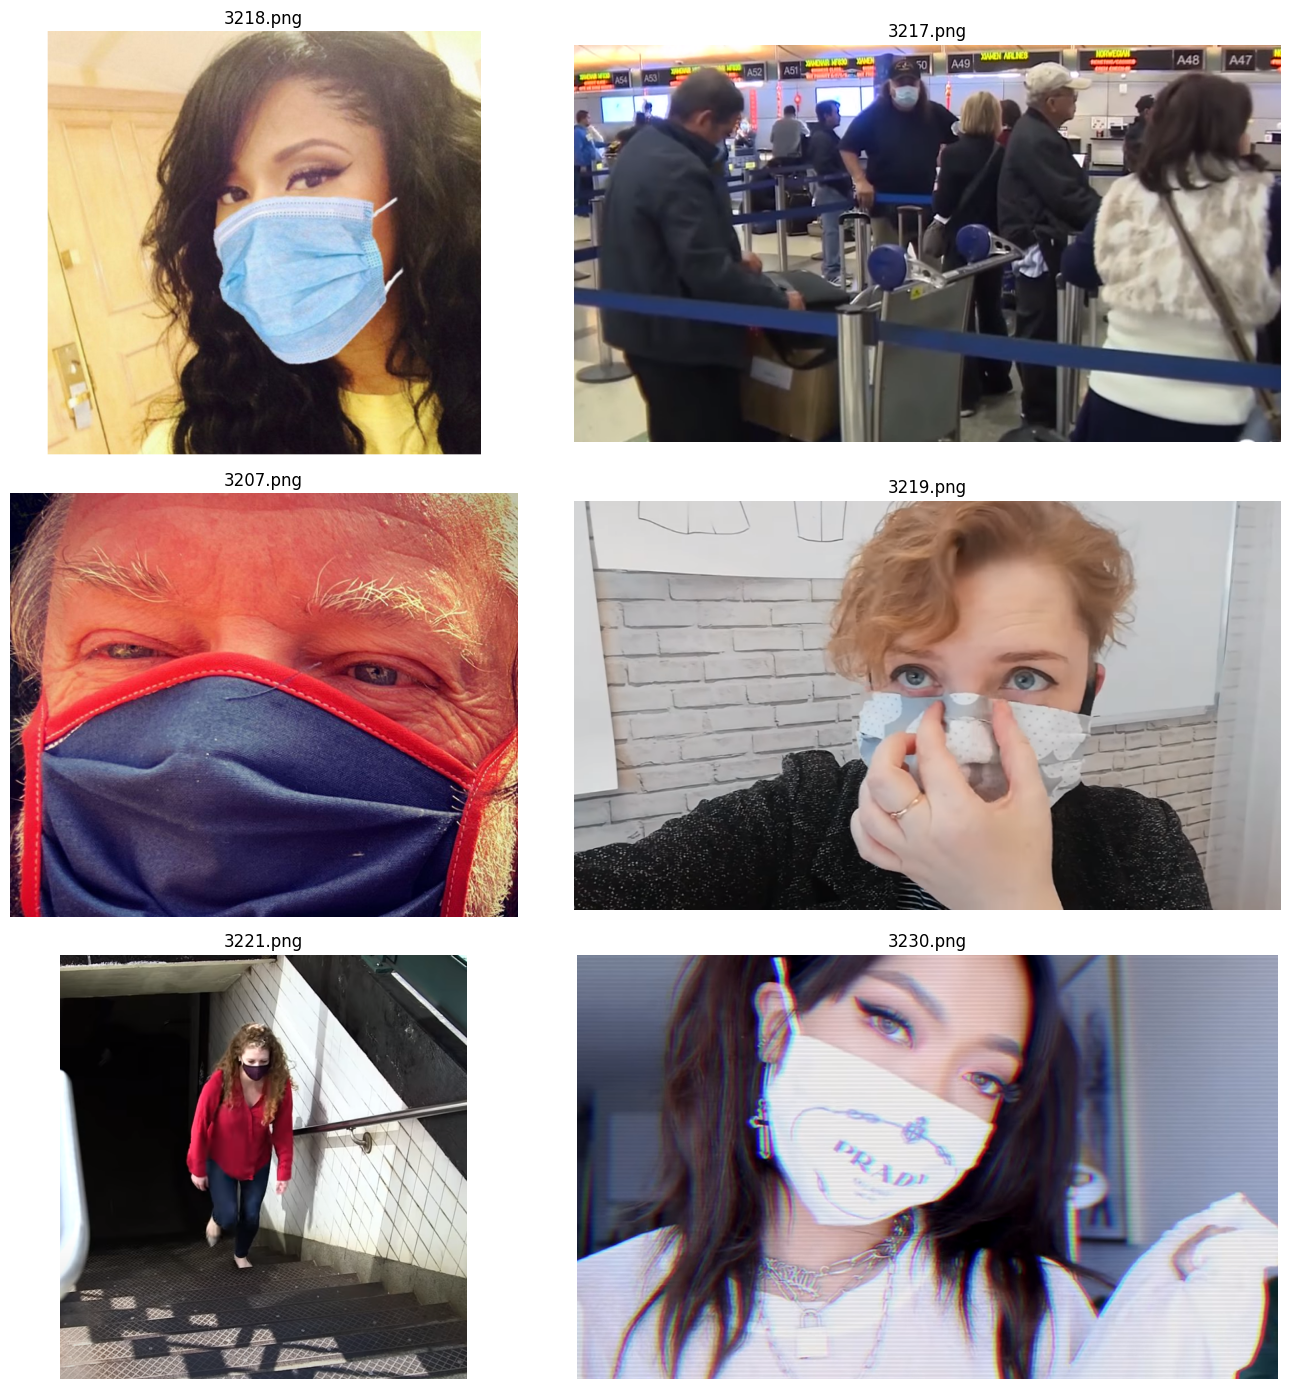

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Define the image directory
image_directory = "/content/drive/MyDrive/face-mask-detection-dataset/Medical mask/Medical Mask/images"

# List all image files in the directory
image_files = [f for f in os.listdir(image_directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Initialize the figure for displaying images
fig = plt.figure(figsize=(14, 14))
rows = 3
cols = 2  # Adjust based on how many images you want to show

# Loop through the first few images to display
for j, image_name in enumerate(image_files[:rows * cols]):
    # Read the image
    image_path = os.path.join(image_directory, image_name)
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    ax = fig.add_subplot(rows, cols, j + 1)
    ax.imshow(image)
    ax.axis('off')  # Hide axis

    # Set title to the image name
    ax.set_title(image_name)

plt.tight_layout()
plt.show()


In [ ]:
!pip install opencv-contrib-python==4.9.0.80
!pip install opencv-python==4.9.0.80

In [ ]:
import cv2
prototxt_path = '/content/drive/MyDrive/face-mask-detection-dataset/deploy.prototxt'
caffemodel_path = '/content/drive/MyDrive/face-mask-detection-dataset/weights.caffemodel'
cvNet = cv2.dnn.readNet(prototxt_path, caffemodel_path)
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [ ]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '5301.jpeg',
 'NumOfAnno': 2,
 'Annotations': [{'isProtected': False,
   'ID': 132741990126842736,
   'BoundingBox': [781, 587, 1268, 1257],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 516635391073281280,
   'BoundingBox': [1609, 703, 2008, 1261],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/face-mask-detection-dataset/train.csv")
df.head()

name   x1   x2   y1   y2       classname
0  2756.png   69  126  294  392  face_with_mask
1  2756.png  505   10  723  283  face_with_mask
2  2756.png   75  252  264  390   mask_colorful
3  2756.png  521  136  711  277   mask_colorful
4  6098.jpg  360   85  728  653    face_no_mask

<Axes: xlabel='count'>

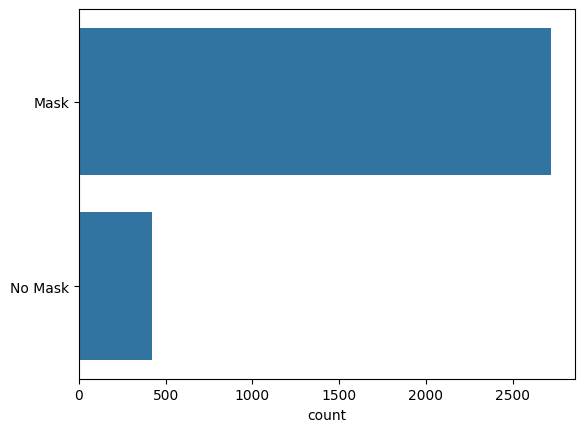

In [ ]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            if img is None:
              continue
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            if img is None:
              continue
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["without mask"]])
random.shuffle(data)

p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

In [ ]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define the model architecture
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(124, 124, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train-validation split
xtrain, xval, ytrain, yval = train_test_split(X, Y, train_size=0.8, random_state=0)

# Initialize ImageDataGenerator with the correct syntax
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

# Fit the data generator to the training data
datagen.fit(xtrain)

# Train the model using the generator
history = model.fit(
    datagen.flow(xtrain, ytrain, batch_size=32),
    steps_per_epoch=xtrain.shape[0] // 32,
    epochs=10,
    verbose=1,
    validation_data=(xval, yval)
)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 668s 8s/step - accuracy: 0.8537 - loss: 0.4803 - val_accuracy: 0.8665 - val_loss: 0.2054
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 49s 514ms/step - accuracy: 0.9062 - loss: 0.1204 - val_accuracy: 0.8649 - val_loss: 0.2756
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 674s 8s/step - accuracy: 0.8779 - loss: 0.2638 - val_accuracy: 0.9110 - val_loss: 0.1966
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 48s 524ms/step - accuracy: 0.9062 - loss: 0.1515 - val_accuracy: 0.9110 - val_loss: 0.1965
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 691s 9s/step - accuracy: 0.8999 - loss: 0.2296 - val_accuracy: 0.9221 - val_loss: 0.2057
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 48s 528ms/step - accuracy: 0.7812 - loss: 0.3863 - val_accuracy: 0.9269 - val_loss: 0.1914
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 647s 8s/step - accuracy: 0.8947 - loss: 0.2201 - val_accuracy: 0.9285 - val_loss: 0.1975
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 47s 532ms/step - accuracy: 0.9062 - loss: 0.2016 - val_accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


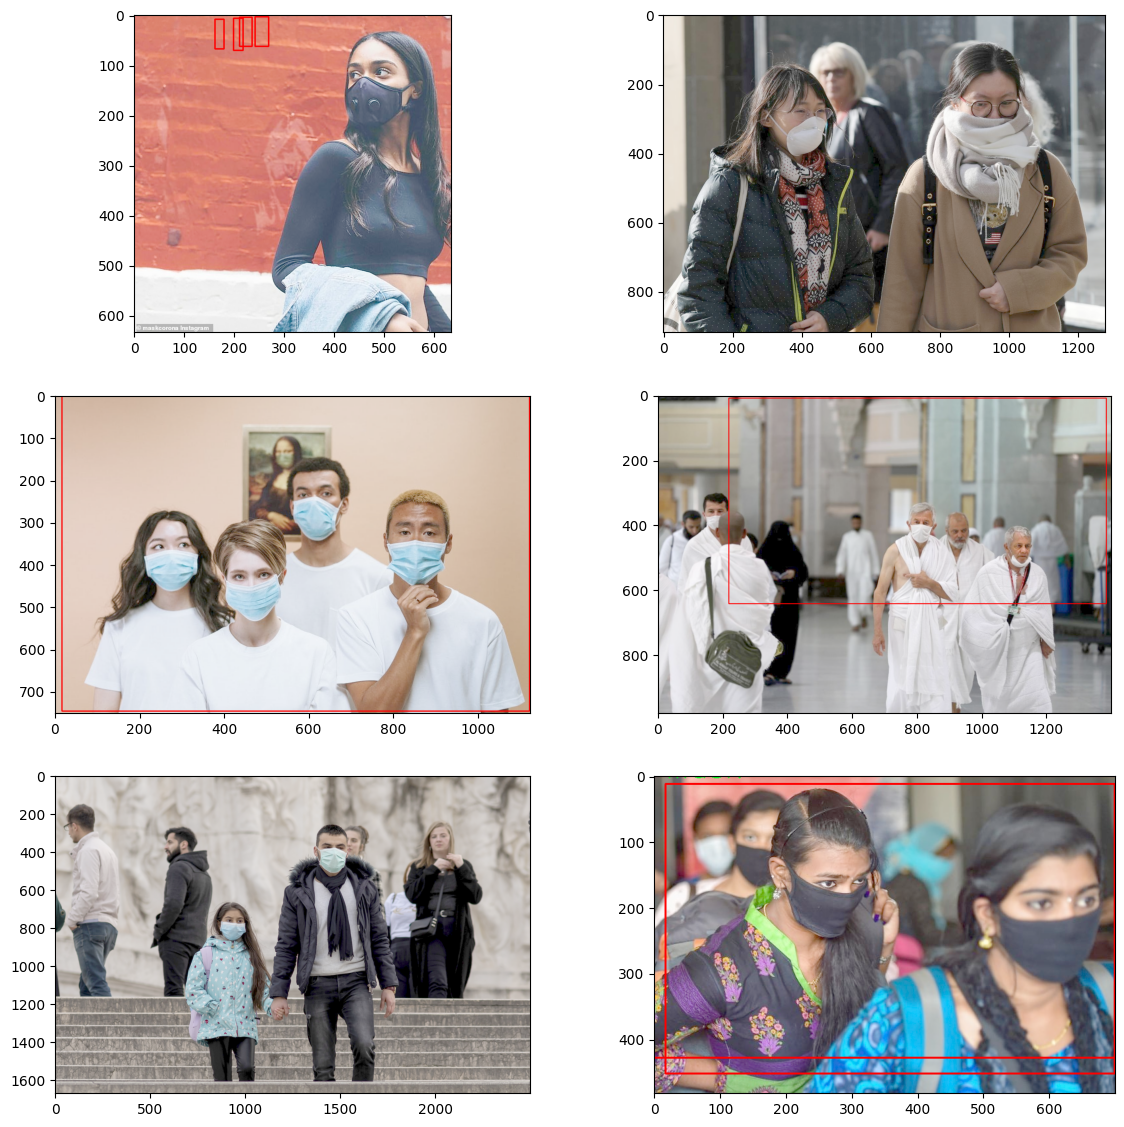

In [ ]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)

        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
